In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from matplotlib.widgets import Slider
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


data = pd.read_csv('dataset/data.csv');

In [150]:
data.isnull().sum() #We have a lot of missing value for cause of death and date of death.
                           # For this analysis I won't use these information because it is a lot missing and I won't get
                           # accurate information if I will analyze them.

# Dropping the 'date_of_death' and 'cause_of_death' columns
data = data.drop(columns=['date_of_death', 'cause_of_death'])


# There are 3 missing values for date of birth so I used median to filled out the missing data.

data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')
data['dob_numeric'] = (data['date_of_birth'] - pd.Timestamp('1970-01-01')).dt.days

median_dob_numeric = data['dob_numeric'].median()
median_date_of_birth = pd.Timestamp('1970-01-01') + pd.to_timedelta(median_dob_numeric, unit='D')

data['date_of_birth'] = data['date_of_birth'].fillna(median_date_of_birth)
data.drop(columns='dob_numeric', inplace=True)

print(data['date_of_birth'].head(10))
data.isnull().sum() # Checking that we do not have any missing values anymore.

0   1921-02-20
1   1935-10-06
2   1942-08-25
3   1942-10-22
4   1937-04-13
5   1935-10-06
6   1943-06-07
7   1949-08-14
8   1943-02-20
9   1949-08-14
Name: date_of_birth, dtype: datetime64[ns]


name             0
reign            0
days             0
date             0
event            0
location         0
link             0
belt             0
date_of_birth    0
dtype: int64

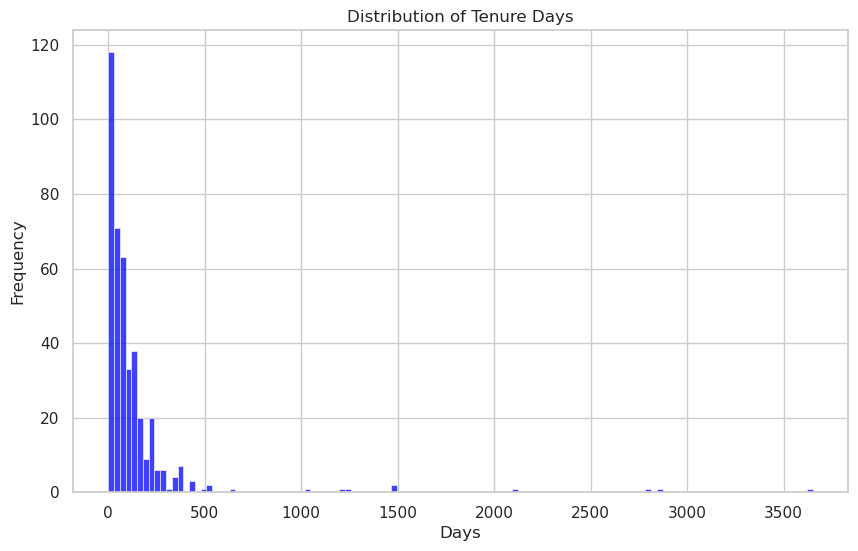

In [151]:
# Histogram of tenure days
plt.figure(figsize=(10, 6))
sns.histplot(data['days'], kde=False, color='blue')
plt.title('Distribution of Tenure Days')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()


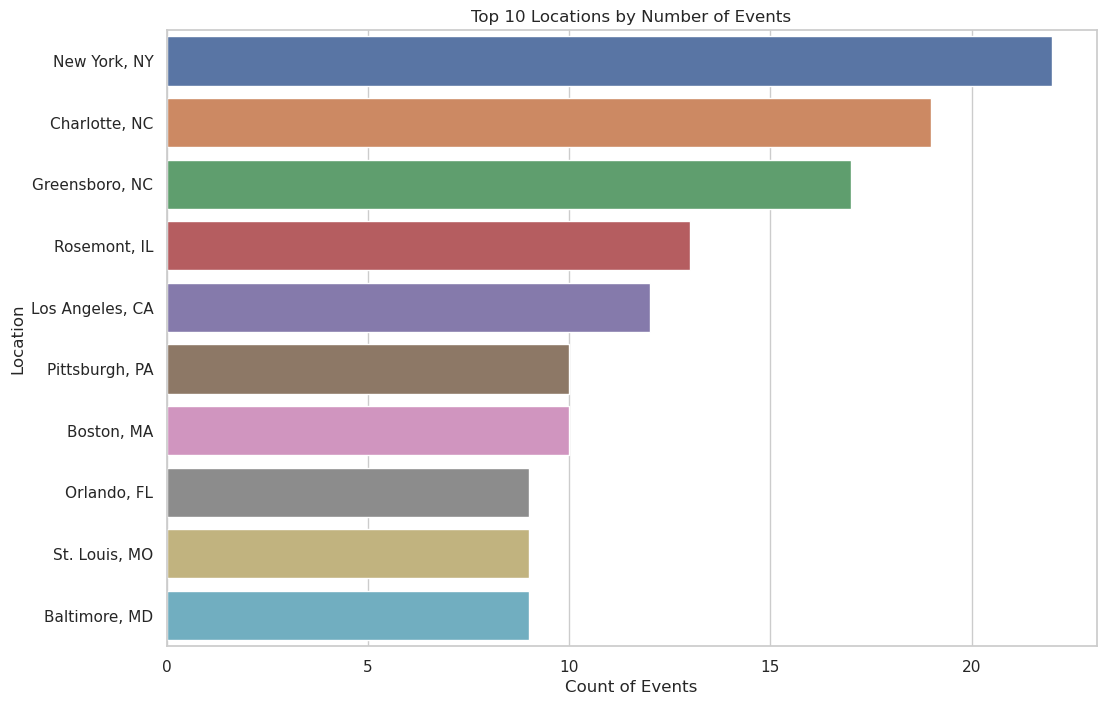

In [152]:
# Bar chart of events by location
plt.figure(figsize=(12, 8))
sns.countplot(y='location', data=data, order=data['location'].value_counts().index[:10])
plt.title('Top 10 Locations by Number of Events')
plt.xlabel('Count of Events')
plt.ylabel('Location')
plt.show()


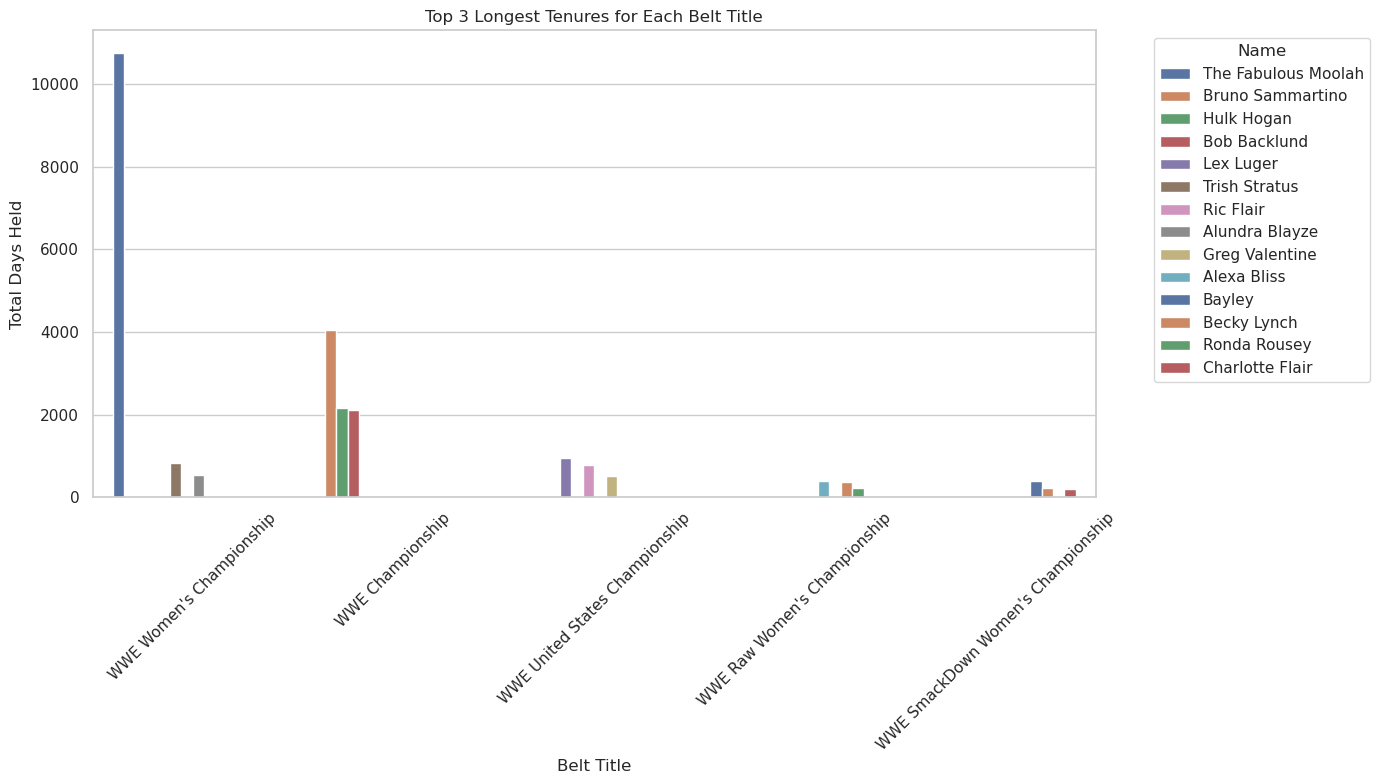

In [153]:
# Who held which titles and for the longest duration,

grouped_data = data.groupby(['belt', 'name']).agg({'days': 'sum'}).reset_index()

top_tenures = grouped_data.sort_values('days', ascending=False).groupby('belt').head(3)

plt.figure(figsize=(14, 8))
sns.barplot(x='belt', y='days', hue='name', data=top_tenures, palette='deep')
plt.title('Top 3 Longest Tenures for Each Belt Title')
plt.xlabel('Belt Title')
plt.ylabel('Total Days Held')
plt.legend(title='Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


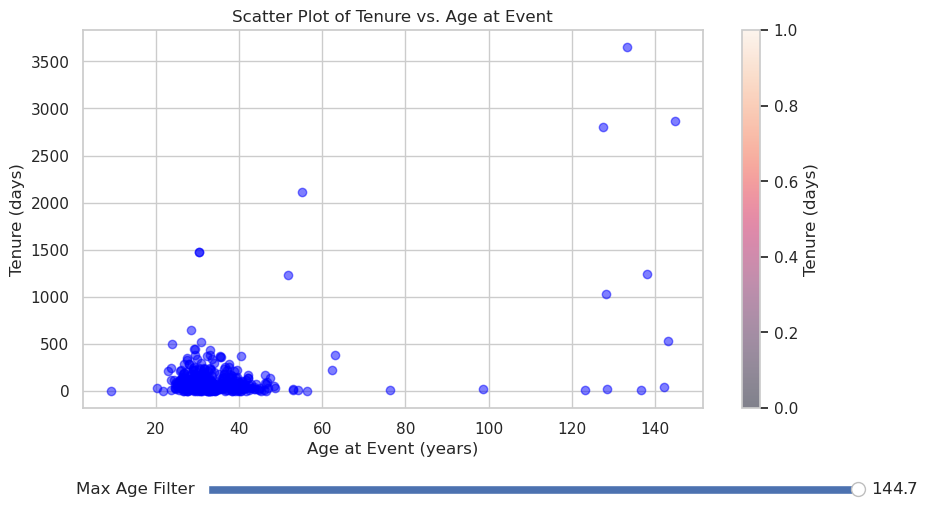

In [154]:
#Tenure vs. Age at Event

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')

data['age_at_event'] = (data['date'] - data['date_of_birth']).dt.total_seconds() / (365.25 * 24 * 3600)  # convert seconds to years

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(data['age_at_event'], data['days'], c='blue', alpha=0.5)
plt.title('Scatter Plot of Tenure vs. Age at Event')
plt.xlabel('Age at Event (years)')
plt.ylabel('Tenure (days)')
plt.colorbar(scatter, label='Tenure (days)')

plt.subplots_adjust(bottom=0.25)
axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
freq_slider = Slider(ax=axfreq, label='Max Age Filter', valmin=data['age_at_event'].min(), valmax=data['age_at_event'].max(), valinit=data['age_at_event'].max())

def update(val):
    age = freq_slider.val
    mask = data['age_at_event'] <= age
    ax.clear()
    ax.scatter(data.loc[mask, 'age_at_event'], data.loc[mask, 'days'], c='blue', alpha=0.5)
    ax.set_xlabel('Age at Event (years)')
    ax.set_ylabel('Tenure (days)')
    ax.set_title('Tenure vs. Age at Event Filtered by Age')
    plt.draw()

freq_slider.on_changed(update)

plt.show()


# Is there a correlation between age and tenure?
# Are there age-specific trends in holding positions?
# Are there outliers in tenure for specific age groups?
# How do tenure patterns change over time?
# Impact of specific events or conditions on tenure

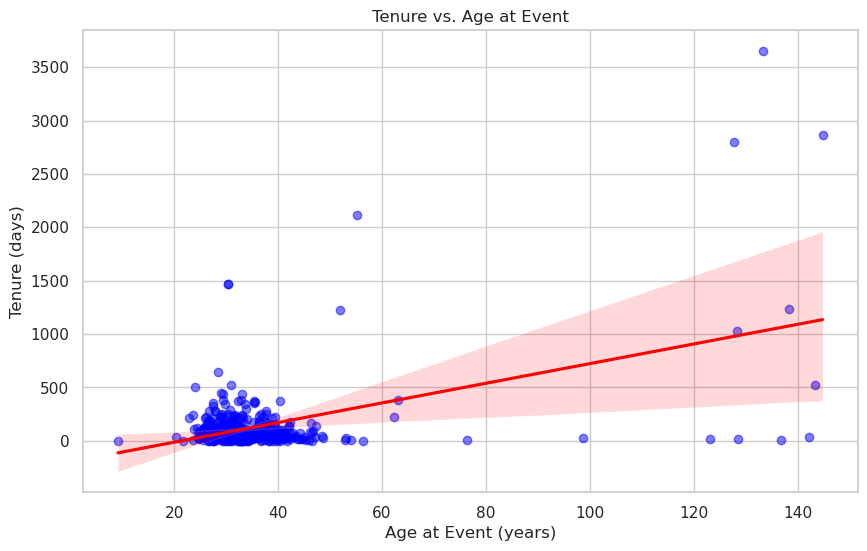

In [155]:
# I decided that I want to analize the first questions and I will use a regression line for getting the result.

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')

data['age_at_event'] = (data['date'] - data['date_of_birth']).dt.total_seconds() / (365.25 * 24 * 3600)  # convert seconds to years

plt.figure(figsize=(10, 6))
sns.regplot(x='age_at_event', y='days', data=data, scatter_kws={'color': 'blue', 'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Tenure vs. Age at Event')
plt.xlabel('Age at Event (years)')
plt.ylabel('Tenure (days)')
plt.show()


By doing a regression line we can say that 'yes', there is a correlation between age and ternure.

* The upward slope suggests that as individuals age, they tend to hold their positions or titles for longer periods. This might indicate that experience or seniority gained over the years contributes to longer tenures.
* It could also imply that stability in positions increases with age. 
*  WWE might perceive older individuals as more trustworthy or reliable, resulting in longer engagements or delays in transitioning roles.

In [156]:

data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')
data['age_at_event'] = (data['date'] - data['date_of_birth']).dt.total_seconds() / (365.25 * 24 * 3600)

data = data.dropna(subset=['age_at_event', 'days'])

X = data[['age_at_event']].values  # Predictor variable
y = data['days'].values  # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

# Error metrics definitions
def mae_metric(y_predict, y_true):
    return np.mean(np.abs(y_predict - y_true))

def sse_metric(y_predict, y_true):
    return np.sum((y_predict - y_true) ** 2)

def mse_metric(y_predict, y_true):
    return np.mean((y_predict - y_true) ** 2)

def rmse_metric(y_predict, y_true):
    return np.sqrt(mse_metric(y_predict, y_true))

def rmsle_metric(y_predict, y_true):
    return np.sqrt(np.mean((np.log1p(y_predict) - np.log1p(y_true)) ** 2))

# Calculate metrics
mae = mae_metric(y_predict, y_test)
sse = sse_metric(y_predict, y_test)
mse = mse_metric(y_predict, y_test)
rmse = rmse_metric(y_predict, y_test)
rmsle = rmsle_metric(y_predict, y_test)

print("MAE:", mae)
print("SSE:", sse)
print("MSE:", mse)
print("RMSE:", rmse)
print("RMSLE:", rmsle)


MAE: 152.53743170833863
SSE: 11871153.547674654
MSE: 144770.16521554455
RMSE: 380.4867477528548
RMSLE: 1.7762673079336122


Because of the type of data I am evaluating I use these error metrics to evaluate if there is a correlation
Between age and tenure, and this is what I got.


1. MAE (Mean Absolute Error): 152.537
This is an average of 152.54 days. This means that, on average, the model's tenure predictions are off by approximately 152.54 days from the actual tenure values.

2. SSE (Sum of Squared Errors): 11,871,153.55
The total squared error of predictions is quite high, suggesting significant variance in the model's errors. Large SSE can indicate the presence of outliers or that the model fits poorly to some data points—potentially those with very high or very low tenures.

3. MSE (Mean Squared Error): 144,770.17
This value tells us that the average squared difference between the predicted tenures and actual tenures is about 144,770.17 days squared. High MSE indicates that this model has a tendency to make errors that are considerably large in some cases. It emphasizes larger errors more than smaller ones due to the squaring of each term.

4. RMSE (Root Mean Squared Error): 380.487
The RMSE value provides a more interpretable metric than MSE because it is on the same scale as the data. An RMSE of 380.49 days indicates that the standard deviation of the prediction errors is about 380 days. This gives a clearer picture of the model error in terms of actual tenure days, highlighting that the errors are substantial.

5. RMSLE (Root Mean Squared Logarithmic Error): 1.776
And the last one, the RMSLE value being 1.776 suggests that there are discrepancies in the prediction of the scale and proportion of the tenure lengths. Since RMSLE penalizes underestimates more severely than overestimates, a high RMSLE might indicate that the model often predicts values significantly lower than actual tenures, especially for larger true values.